In [41]:
import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as stats
import scipy.stats as ss
from matplotlib import style
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
import pandas as pd

from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn

plt.style.context("seaborn-whitegrid")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25


visualize all cnvs in one plot

In [42]:
# f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/Cervical_124_patients_adjusted/cnv_files_for_acen_removal.txt'
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cleaned_cnv_files.txt'
df1 = pd.read_csv(f1, sep='\t', header=None, comment='#')
df1.columns = ['patient', 'seg_path']
assert df1.shape[0] == 124
df1.head(2)

,patient,seg_path
0,HTMCP-03-06-02001,/projects/trans_scratch/validations/workspace/...
1,HTMCP-03-06-02002,/projects/trans_scratch/validations/workspace/...


In [43]:
df2 = pd.DataFrame()
for idx, row in df1.iterrows():
    pat = row['patient']
    seg_file = row['seg_path']
#     print(pat, seg_file)
    # cnv_files, some rows have 10 columns instead of 9, problems from the APLcnv pipeline
    cnv = pd.read_csv(seg_file, sep='\t',  error_bad_lines=False, warn_bad_lines=True)
    cnv.columns = ['chr', 'start', 'end', 'cn']
    cnv = cnv[cnv.cn != 2]
    cnv['patient'] = pat
    if df2.empty:
        df2 = cnv
    else: df2 = pd.concat([df2,cnv])

In [5]:
df2.head(2)

,chr,start,end,cn,patient
0,1,416575,564606,4,HTMCP-03-06-02001
1,1,564607,569345,1,HTMCP-03-06-02001


In [6]:
df2.shape

(41838, 5)

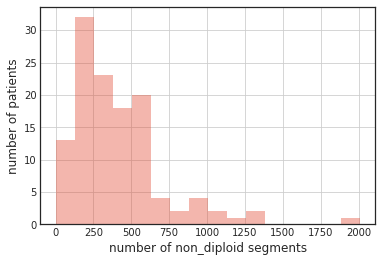

In [6]:
# non-diploid segments distribution by patient
segments = df2.groupby('patient').count().sort_values('cn', ascending=False)['cn']

# distribution of number of segments
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w')
    sns.distplot(segments, kde=False)
    plt.xlabel('number of non_diploid segments')
    plt.ylabel('number of patients')

In [7]:
# patients with exactly the same cnv breakpoints
df2.groupby(['chr', 'start', 'end']).count().sort_values('patient', ascending=False).head(2)

,,,cn,patient
chr,start,end,,
16,46391125,46391604,3,3
2,92316257,92318263,2,2


In [8]:
df2.head(2)

,chr,start,end,cn,patient
0,1,416575,564606,4,HTMCP-03-06-02001
1,1,564607,569345,1,HTMCP-03-06-02001


In [44]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_cleaned.txt'
df2[df2.cn >2].to_csv(of, index=False, header=None, sep='\t')

In [45]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_cleaned.txt'
df2[df2.cn <2].to_csv(of, index=False, header=None, sep='\t')

run this in this dir: /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/

sort -k1n -k2n -k3n amps_cleaned.txt > amps_cleaned.txt.sorted

sort -k1n -k2n -k3n dels_cleaned.txt > dels_cleaned.txt.sorted

bedtools intersect -a chr_bins.txt -b dels_cleaned.txt.sorted -wa -wb > dels_cleaned_bins_1kb.txt

bedtools intersect -a chr_bins.txt -b amps_cleaned.txt.sorted -wa -wb > amps_cleaned_bins_1kb.txt


In [46]:
patients = df2.patient.value_counts().index.tolist()

In [47]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_cleaned_bins_1kb.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
recur_amps = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_cleaned_bins_1kb_patients.txt'
recur_amps.to_csv(f, index=False, sep='\t')
# recur_amps = pd.read_csv(f, sep='\t')

In [48]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_cleaned_bins_1kb.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
recur_dels = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_cleaned_bins_1kb_patients.txt'
recur_dels.to_csv(f, index=False, sep='\t')
# recur_dels = pd.read_csv(f, sep='\t')

In [51]:
# 1 patient has no cnv?
len(patients)

122

In [52]:
# plot chromosomes
f3 = '/home/szong/projects/resource/hg19_cytoband_ucsc.txt'
df3 = pd.read_csv(f3, header=None, sep='\t')
df3.columns = ['chr', 'start', 'end', 'cytoband', 'comments']
df3.head(2)

,chr,start,end,cytoband,comments
0,1,0,2300000,p36.33,gneg
1,1,2300000,5400000,p36.32,gpos25


In [10]:
# patients = ['HTMCP-03-06-02071', 'HTMCP-03-06-02330', 'HTMCP-03-06-02441']

In [12]:
# patients

In [53]:
df2.head(2)

,chr,start,end,cn,patient
0,1,416575,564606,4,HTMCP-03-06-02001
1,1,564607,569345,1,HTMCP-03-06-02001


In [ ]:
# f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_bins_1kb.txt'
# df = pd.read_csv(f, sep='\t', header=None)
# df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']#, 'length']
# occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
# recur_amps = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])
# recur_amps.head()

In [27]:
# f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_bins_1kb_patients.txt'
# recur_amps.to_csv(f, index=False, sep='\t')

In [ ]:
# f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_bins_1kb.txt'
# df = pd.read_csv(f, sep='\t', header=None)
# df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']#, 'length']
# df = df[['bin_chr', 'bin_start', 'bin_end','patient']]
# occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
# recur_dels = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])

In [28]:
# f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_bins_1kb_patients.txt'
# recur_dels.to_csv(f, index=False, sep='\t')


processing chr 1 and the chr_offset is 0
plotting amp aggregation


/projects/da_workspace/software/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/projects/da_workspace/software/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


plotting del aggregation
processing chr 2 and the chr_offset is 249250621
plotting amp aggregation
plotting del aggregation
processing chr 3 and the chr_offset is 492449994
plotting amp aggregation
plotting del aggregation
processing chr 4 and the chr_offset is 690472424
plotting amp aggregation
plotting del aggregation
processing chr 5 and the chr_offset is 881626700
plotting amp aggregation
plotting del aggregation
processing chr 6 and the chr_offset is 1062541960
plotting amp aggregation
plotting del aggregation
processing chr 7 and the chr_offset is 1233657027
plotting amp aggregation
plotting del aggregation
processing chr 8 and the chr_offset is 1392795690
plotting amp aggregation
plotting del aggregation
processing chr 9 and the chr_offset is 1539159712
plotting amp aggregation
plotting del aggregation
processing chr 10 and the chr_offset is 1680373143
plotting amp aggregation
plotting del aggregation
processing chr 11 and the chr_offset is 1815907890
plotting amp aggregation
pl

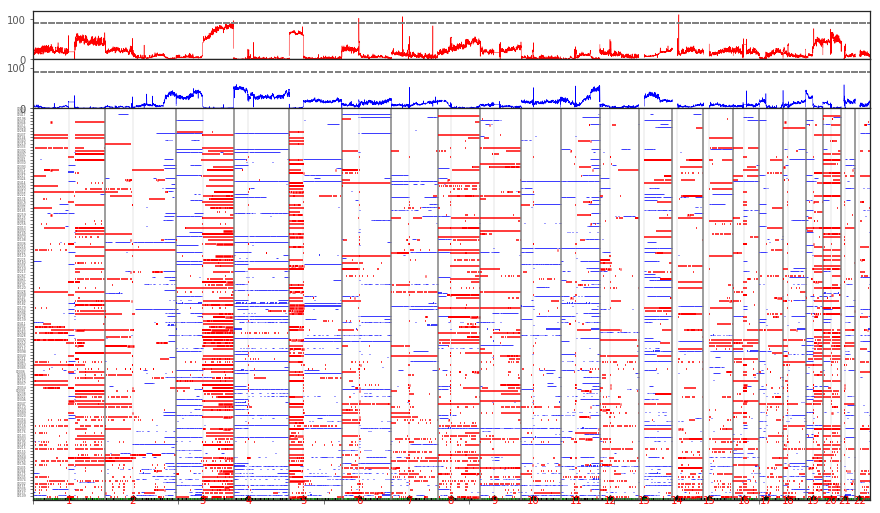

In [65]:
# new code 20180606 this plot all segments, small segment may not show up because length are on scale
df_segs = df2.copy()
# fig = plt.figure(figsize=with plt.style.context("seaborn-white"):
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
#     fig = plt.figure(facecolor='w', figsize=(15,9))
fig = plt.figure(figsize=(15, 9), facecolor='white')
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,8],
                       wspace=0.05, # horizontal space
                       hspace=0.0  # vertical space
                      )

ax0 = fig.add_subplot(gs[0], facecolor='white')
ax1 = fig.add_subplot(gs[1], facecolor='white')
ax2 = fig.add_subplot(gs[2], facecolor='white')
chr_offset = 0 # chromosome offset
num_patients = len(patients)
#     ylim = 4
ylim = num_patients/10.0+0.1
for chr in np.arange(1,23):
    print('processing chr {0} and the chr_offset is {1}'.format(chr, chr_offset))
    dfchr = df_cytoband[df_cytoband.chr=='{}'.format(chr)]
    clrs = ['-k', '-g']*100

    num_segs = dfchr.shape[0]
    # plot centromere
    acen = dfchr[dfchr.comments=='acen'].reset_index().loc[0, 'end'] + chr_offset
    ax2.plot(acen, 0.1, color='black',marker='D', markersize=4)
    ax2.axvline(x=acen, color='gray', linewidth=0.2)
    ax2.text(acen, -.25, '{}'.format(chr), color='red', horizontalalignment='center')

    clrs = clrs[:num_segs]
    i = 0 # color index
    for idx, row in dfchr.iterrows():
        start = row.start + chr_offset
        end = row.end + chr_offset
        cytoband = row.cytoband
        comment = row.comments
        center = (start + end)/2 + chr_offset
        width = int(end - start)
        ax2.plot((start, end), (0.05,0.05), clrs[i], linewidth=3, solid_capstyle='butt')        
        i+=1


    # draw chromosome boundary
    ax2.axvline(x=chr_offset, color='gray')


    # plot amp aggregate results
    amps = recur_amps.query('bin_chr == {0}'.format(chr))
    print('plotting amp aggregation')
    amps['x'] = amps.bin_start + chr_offset
    ax0.plot(amps.x, amps.patient, color='red', linewidth=.5, solid_capstyle='butt')
    ax0.axhline(y=0.75*num_patients, color='gray', linestyle='dashed')

    # plot del aggregate results
    dels = recur_dels.query('bin_chr == {0}'.format(chr))
    print('plotting del aggregation')
    dels['x'] = dels.bin_start + chr_offset
    ax1.plot(dels.x, dels.patient, color='blue', linewidth=.5, solid_capstyle='butt')
    ax1.axhline(y=0.75*num_patients, color='gray', linestyle='dashed')


    # plot cnvs
    j = 0 # row offset
    yticks = []
    cnvy_coords = []
    for patient in patients: 
#             print('plotting patient {0}, cnvy_coords is {1}'.format(patient, 0.2+j))
        # plot amplification
        amps = df_segs.query('chr == {0} & patient == "{1}" & cn > 2'.format(chr, patient))
        m=0 #test label offset to be deleted
        for idx, row in amps.iterrows():
            start = row.start + chr_offset
            end = row.end + chr_offset
            length = end - start
            cn = row.cn
#                 if chr == 7 or chr ==14:
#                     print('plotting amps line {0}:{1}-{2}, cn {3}, length {4}'.format(chr, row.start, row.end, cn, row.end-row.start))


#                 it looks like can not see anything <150000 on a 3 billion scale, so magnfiy anything to 150000
#             if length < 150000:
# #                 end = start + 150000
#                 print('{0} {1} has a amp < 150kb {2}: {3}: {4}'.format(patient, chr, start, end-start, cn))
            ax2.plot((start, end), (0.2+j, 0.2+j), color='red',  linewidth=cn*0.5, solid_capstyle='butt')
#                 ax2.text(start, 0.2+m, str(row.start))
#                 m+=0.2
        # plot deletion
        dels = df_segs.query('chr == {0} & patient == "{1}" & cn < 2'.format(chr, patient))
        for idx, row in dels.iterrows():
            start = row.start + chr_offset
            end = row.end + chr_offset
            length = end - start
            cn = row.cn
#             if length < 150000:
# #                 end = start + 150000
#                 print('{0} {1} has a del < 150kb {2}'.format(patient, chr, start))
            del_w = 2 - cn
            ax2.plot((start, end), (0.3+j, 0.3+j), color='blue', linewidth=del_w*0.75, solid_capstyle='butt')
        yticks.append(0.25+j)
        j+=0.2
    chr_offset+=max(dfchr.end)
ax0.set_xlim(0, chr_offset)
ax0.set_ylim(0, num_patients)
ax1.set_xlim(0, chr_offset)
ax1.set_ylim(0, num_patients)
ax2.set_xlim(0, chr_offset)
ax2.set_ylim(0, ylim)
ax0.set_xticklabels('')
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax2.set_yticks(yticks)
ax2.set_yticklabels([i.split('-')[3] for i in patients], fontsize=3)
#     plt.tight_layout()
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_123_patients_test.png'
plt.savefig(of, dpi=800)
plt.show()#(15, 9), facecolor='white')

    

SyntaxError: invalid syntax (<ipython-input-82-cc84e79ee737>, line 1)

In [33]:
df2.head(2)

,chr,start,end,cn,patient
0,1,416575,564606,4,HTMCP-03-06-02001
1,1,564607,569345,1,HTMCP-03-06-02001


In [39]:
# recurrent amps on chr14 not removed? why
df2tmp = df2.query('chr =="{0}" & start > {1} & end < {2}'.format(14,22465001, 22969001))
# 22465001	22969001
(df2tmp.end - df2tmp.start).head()

375    404157
106    338642
674    338652
414    390948
60     373630
dtype: int64

processing chr 1 and the chr_offset is 0
plotting amp aggregation


/projects/da_workspace/software/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/projects/da_workspace/software/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


plotting del aggregation
processing chr 2 and the chr_offset is 249250621
plotting amp aggregation
plotting del aggregation
processing chr 3 and the chr_offset is 492449994
plotting amp aggregation
plotting del aggregation
processing chr 4 and the chr_offset is 690472424
plotting amp aggregation
plotting del aggregation
processing chr 5 and the chr_offset is 881626700
plotting amp aggregation
plotting del aggregation
processing chr 6 and the chr_offset is 1062541960
plotting amp aggregation
plotting del aggregation
processing chr 7 and the chr_offset is 1233657027
plotting amp aggregation
plotting del aggregation
processing chr 8 and the chr_offset is 1392795690
plotting amp aggregation
plotting del aggregation
processing chr 9 and the chr_offset is 1539159712
plotting amp aggregation
plotting del aggregation
processing chr 10 and the chr_offset is 1680373143
plotting amp aggregation
plotting del aggregation
processing chr 11 and the chr_offset is 1815907890
plotting amp aggregation
pl

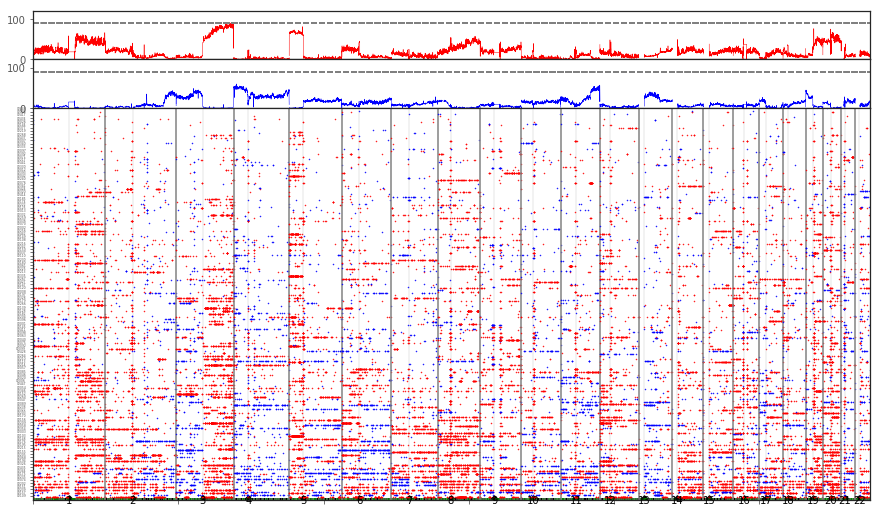

In [54]:
# new code 20180606 this is only to plot segments <1mb, not showing the cn or seg length, only +
df_segs = df2.copy()
df_cytoband = df3.copy()
# fig = plt.figure(figsize=with plt.style.context("seaborn-white"):
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
#     fig = plt.figure(facecolor='w', figsize=(15,9))
fig = plt.figure(figsize=(15, 9), facecolor='white')
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,8],
                       wspace=0.05, # horizontal space
                       hspace=0.0  # vertical space
                      )

ax0 = fig.add_subplot(gs[0], facecolor='white')
ax1 = fig.add_subplot(gs[1], facecolor='white')
ax2 = fig.add_subplot(gs[2], facecolor='white')
chr_offset = 0 # chromosome offset
num_patients = len(patients)
#     ylim = 4
ylim = num_patients/10.0+0.1
for chr in np.arange(1,23):
    print('processing chr {0} and the chr_offset is {1}'.format(chr, chr_offset))
    dfchr = df_cytoband[df_cytoband.chr=='{}'.format(chr)]
    clrs = ['-k', '-g']*100

    num_segs = dfchr.shape[0]
    # plot centromere
    acen = dfchr[dfchr.comments=='acen'].reset_index().loc[0, 'end'] + chr_offset
    ax2.plot(acen, 0.1, color='black',marker='D', markersize=4)
    ax2.axvline(x=acen, color='gray', linewidth=0.2)
    ax2.text(acen, -.25, '{}'.format(chr), color='black', horizontalalignment='center')

    clrs = clrs[:num_segs]
    i = 0 # color index
    for idx, row in dfchr.iterrows():
        start = row.start + chr_offset
        end = row.end + chr_offset
        cytoband = row.cytoband
        comment = row.comments
        center = (start + end)/2 + chr_offset
        width = int(end - start)
        ax2.plot((start, end), (0.05,0.05), clrs[i], linewidth=3, solid_capstyle='butt')        
        i+=1


    # draw chromosome boundary
    ax2.axvline(x=chr_offset, color='gray')


    # plot amp aggregate results
    amps = recur_amps.query('bin_chr == {0}'.format(chr))
    print('plotting amp aggregation')
    amps['x'] = amps.bin_start + chr_offset
    ax0.plot(amps.x, amps.patient, color='red', linewidth=.5, solid_capstyle='butt')
    ax0.axhline(y=0.75*num_patients, color='gray', linestyle='dashed')

    # plot del aggregate results
    dels = recur_dels.query('bin_chr == {0}'.format(chr))
    print('plotting del aggregation')
    dels['x'] = dels.bin_start + chr_offset
    ax1.plot(dels.x, dels.patient, color='blue', linewidth=.5, solid_capstyle='butt')
    ax1.axhline(y=0.75*num_patients, color='gray', linestyle='dashed')


    # plot cnvs
    j = 0 # row offset
    yticks = []
    cnvy_coords = []
    for patient in patients: 
#             print('plotting patient {0}, cnvy_coords is {1}'.format(patient, 0.2+j))
        # plot amplification
        amps = df_segs.query('chr == {0} & patient == "{1}" & cn > 2'.format(chr, patient))
        m=0 #test label offset to be deleted
        for idx, row in amps.iterrows():
            start = row.start + chr_offset
            end = row.end + chr_offset
            length = end - start
            cn = row.cn
#                 if chr == 7 or chr ==14:
#                     print('plotting amps line {0}:{1}-{2}, cn {3}, length {4}'.format(chr, row.start, row.end, cn, row.end-row.start))


#                 it looks like can not see anything <150000 on a 3 billion scale, so magnfiy anything to 150000
            if length < 1e6:
                pos = 0.5*(start + end)
#                 end = start + 150000
#                 print('{0} {1} has a amp < 150kb {2}: {3}: {4}'.format(patient, chr, pos, end-start, cn))
                ax2.plot(pos, 0.2+j, color='red', marker='.', markersize=1)# solid_capstyle='butt')
#                 ax2.text(start, 0.2+m, str(row.start))
#                 m+=0.2
        # plot deletion
        dels = df_segs.query('chr == {0} & patient == "{1}" & cn < 2'.format(chr, patient))
        for idx, row in dels.iterrows():
            start = row.start + chr_offset
            end = row.end + chr_offset
            length = end - start
            cn = row.cn
            if length < 1e6:
                pos = 0.5*(start + end)
#                 end = start + 150000
#                 print('{0} {1} has a del < 150kb {2}'.format(patient, chr, start))
                del_w = 2 - cn
                ax2.plot(pos, 0.3+j, color='blue', marker='.', markersize=1)
        yticks.append(0.25+j)
        j+=0.2
    chr_offset+=max(dfchr.end)
ax0.set_xlim(0, chr_offset)
ax0.set_ylim(0, num_patients)
ax1.set_xlim(0, chr_offset)
ax1.set_ylim(0, num_patients)
ax2.set_xlim(0, chr_offset)
ax2.set_ylim(0, ylim)
ax0.set_xticklabels('')
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax2.set_yticks(yticks)
ax2.set_yticklabels([i.split('-')[3] for i in patients], fontsize=3)
#     plt.tight_layout()
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_123_patients_cleaned.png'
plt.savefig(of, dpi=800)
plt.show()#(15, 9), facecolor='white')

    

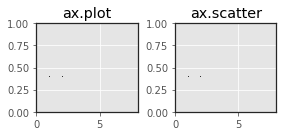

In [115]:

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax, sharey=ax)
ax.plot([1, 2],[0.4,0.4], marker='o',ms=72./fig.dpi, mew=0, 
        color='black', linestyle="", lw=0)
ax.set_title("ax.plot")
ax2.scatter([1,2],[0.4,0.4],color='black', marker='o', lw=0, s=(72./fig.dpi)**2)
ax2.set_title("ax.scatter")
ax.set_xlim(0,8)
ax.set_ylim(0,1)
fig.tight_layout()

of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_123_patients_test.png'
fig.savefig(of, dpi=fig.dpi)
# plt.savefig(of, dpi=200)

# below code depreciated

processing 20
processing 21
processing 22


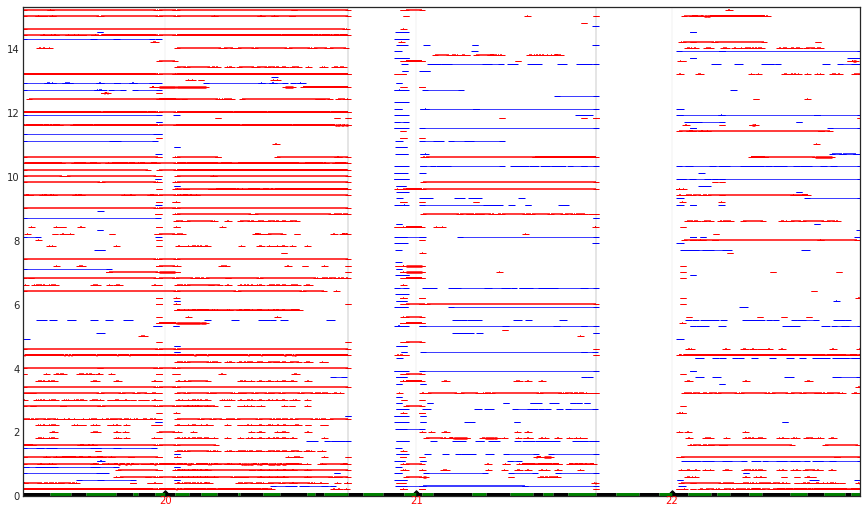

In [18]:
# depreciated code
# gs = gridspec.GridSpec(2, 1, width_ratios=[1,50], 
#                        wspace=0.05, # horizontal space
#                        hspace=0.0  # vertical space
#                       )
                       
df_cytoband = df3.copy()
df_cnvs = df2.copy()
with plt.style.context("seaborn-white"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(15,9))
#     ax1 = fig.add_subplot(gs[0], facecolor='white')
    ax1 = fig.add_subplot(111)
    accu_pos = 0 # chromosome offset
    ylim = len(patients)/10.0+0.1+3
    for chr in np.arange(20,23):
        print('processing {}'.format(chr))
        dfchr = df_cytoband[df_cytoband.chr=='{}'.format(chr)]
        clrs = ['-k', '-g']*100
        i = 0 # color index
        
        # plot centromere
        num_segs = dfchr.shape[0]
        acen = dfchr[dfchr.comments=='acen'].reset_index().loc[0, 'end'] + accu_pos
        ax1.plot(acen, 0.1, color='black',marker='D', markersize=4)
        ax1.axvline(x=acen, color='gray', linewidth=0.1)
        ax1.text(acen, -.25, '{}'.format(chr), color='red', horizontalalignment='center')

        clrs = clrs[:num_segs]

        for idx, row in dfchr.iterrows():
            start = row.start + accu_pos
            end = row.end + accu_pos
            cytoband = row.cytoband
            comment = row.comments
            center = (start + end)/2 + accu_pos
            width = int(end - start)
            ax1.plot((start, end), (0.05,0.05), clrs[i], linewidth=3,
                     solid_capstyle='butt')        
            i+=1


        # draw chromosome boundary
        ax1.axvline(x=accu_pos, color='black', linewidth=0.2)

        # plot cnvs
        j = 0 # row offset
        for patient in patients:    
            # plot amplification
            amps = df_cnvs.query('chr == {0} & patient == "{1}" & cn > 2'.format(chr, patient))
            for idx, row in amps.iterrows():
                start = row.start + accu_pos
                end = row.end + accu_pos
                cn = row.cn
                ax1.plot((start, end), (0.2+j, 0.2+j), color='red', marker='_', 
                         linewidth=cn*0.5, solid_capstyle='butt')

            # plot deletion
            dels = df_cnvs.query('chr == {0} & patient == "{1}" & cn < 2'.format(chr, patient))
            for idx, row in dels.iterrows():
                start = row.start + accu_pos
                end = row.end + accu_pos
                cn = row.cn
                del_w = 2 - cn
                ax1.plot((start, end), (0.3+j, 0.3+j), color='blue', marker='_', 
                         linewidth=del_w*0.75, solid_capstyle='butt')

            j+=0.2
        accu_pos+=max(dfchr.end)
    ax1.set_xlim(0, accu_pos)
    ax1.set_ylim(0, ylim)
    ax1.set_xticklabels('')
    # plt.tight_layout()
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_123_patients.png'
#     plt.savefig(of, dpi=800)
    plt.show()

In [258]:
ax1.plot?

look at GISTIC amp and del peak length distribution

In [15]:
# generate 3 million bins for the whole genome
f1 = '/home/szong/projects/resource/chrominfo.txt'
chrominfo = pd.read_csv(f1, sep='\t', index_col='#chrom')
chrominfo.columns = ['size', 'file_name']
chrominfo.head(2)

,size,file_name
#chrom,,
chr1,249250621,/gbdb/hg19/hg19.2bit
chr2,243199373,/gbdb/hg19/hg19.2bit


In [31]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/chr_bins.txt'
with open(of,  'w') as fh:
    writer = csv.writer(fh, delimiter='\t')
    for i in np.arange(1, 23):
        chr = 'chr{}'.format(i)

        # ignoring the chromosome 1kb tail for now   
        chr_size = chrominfo.loc[chr, 'size']
        stride = 1000
        bin1 = np.arange(1, chr_size, stride)
        bin2 = np.arange(stride, chr_size+stride, stride)
        bin_len = min(len(bin1), len(bin2))
        bin1 = bin1[:bin_len]
        bin2 = bin2[:bin_len]
        bins = list(zip([i]*len(bin1), bin1, bin2))




        for item in bins:
            writer.writerow(item)
# need to use this line to remove special character
# cat chr_bins.txt|sed $'s/[^[:print:]\t]//g' >b.tmp 

# find systematic cnv noise

In [29]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_bins_1kb.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
df.head(2)

,bin_chr,bin_start,bin_end,chr,start,end,cn,patient
0,1,10001,11000,1,10654,19428,4,HTMCP-03-06-02002
1,1,11001,12000,1,10654,19428,4,HTMCP-03-06-02002


In [30]:
occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end'])['patient'].nunique().sort_values(ascending=False)

In [31]:
occurrence.head(2)

bin_chr  bin_start  bin_end 
14       22880001   22881000    112
         22733001   22734000    112
Name: patient, dtype: int64

In [32]:
recur_amps = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])

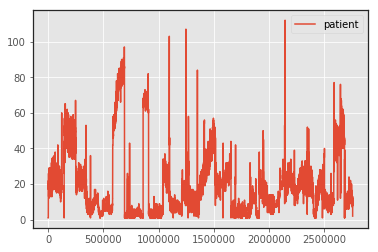

In [33]:
recur_amps.patient.reset_index().drop('index', axis=1).plot()

In [34]:
recur_amps.head()

,bin_chr,bin_start,bin_end,patient
2757019,1,10001,11000,1
2677781,1,11001,12000,1
2677782,1,12001,13000,1
2677783,1,13001,14000,1
2677784,1,14001,15000,1


In [40]:
df3.head(2)

,chr,start,end,cytoband,comments
0,1,0,2300000,p36.33,gneg
1,1,2300000,5400000,p36.32,gpos25


In [ ]:
df_cytoband = df3.copy()
with plt.style.context("seaborn-white"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(15,9))
    ax1 = fig.add_subplot(111)
    accu_pos = 0 # chromosome offset
    ylim = len(patients)/10.0+0.1
    for chr in np.arange(1, 3):#23):
        print('processing {}'.format(chr))
        dfchr = df_cytoband[df_cytoband.chr=='{}'.format(chr)]
        clrs = ['-k', '-g']*100
        i = 0 # color index
        num_segs = dfchr.shape[0]
        
        # plot centromere
        acen = dfchr[dfchr.comments=='acen'].reset_index().loc[0, 'end'] + accu_pos
        ax1.plot(acen, 0.1, color='black',marker='D', markersize=4)
        ax1.axvline(x=acen, color='gray', linewidth=0.1)
        ax1.text(acen, -.25, '{}'.format(chr), color='red', horizontalalignment='center')
        
        
        
        # plot cytoband
        clrs = clrs[:num_segs]
        for idx, row in dfchr.iterrows():
            start = row.start + accu_pos
            end = row.end + accu_pos
            cytoband = row.cytoband
            comment = row.comments
            center = (start + end)/2 + accu_pos
            width = int(end - start)
            ax1.plot((start, end), (0.05,0.05), clrs[i], linewidth=3,
                     solid_capstyle='butt')        
            i+=1

        
        # draw chromosome boundary
        ax1.axvline(x=accu_pos, color='black', linewidth=0.2)
        
        # plot cnvs
        j = 0 # row offset

        # plot amplification
        amps = recur_amps.query('bin_chr == {0}'.format(chr))
        print('plotting amp aggregation')
        recur_amps.patient.reset_index().drop('index', axis=1).plot()
        for idx, row in amps.iterrows():
            start = row.bin_start + accu_pos
            end = row.bin_end + accu_pos
            num_patients = row.patient
            ax1.plot((start, end), (0.2, 0.2), color='red', marker='_', 
                     linewidth=num_patients*0.5, solid_capstyle='butt')

#         # plot deletion
#         dels = df2.query('chr == {0} & patient == "{1}" & cn < 2'.format(chr, patient))
#         for idx, row in dels.iterrows():
#             start = row.start + accu_pos
#             end = row.end + accu_pos
#             cn = row.cn
#             del_w = 2 - cn
#             ax1.plot((start, end), (0.3+j, 0.3+j), color='blue', marker='_', 
#                      linewidth=del_w*0.75, solid_capstyle='butt')

#             j+=0.2
        accu_pos+=max(dfchr.end)
    ax1.set_xlim(0, accu_pos)
    ax1.set_ylim(0, ylim)
    ax1.set_xticklabels('')
    plt.tight_layout()
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_123_patients.png'
#     plt.savefig(of, dpi=800)
    plt.show()

processing 1
plotting amp aggregation


KeyboardInterrupt: 

# outdated code snippets

249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621
249250621


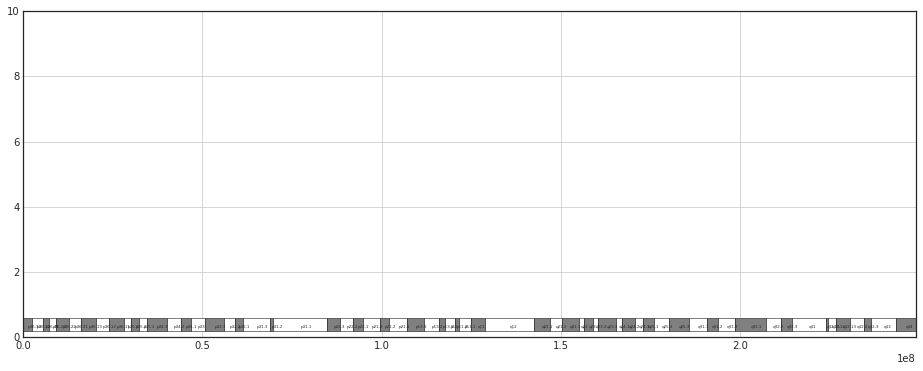

In [26]:
# plot cytoband hg19
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(16,6))
    ax1 = fig.add_subplot(111)
    clrs = ['gray', 'white']*100
    i = 0
    
    dfchr = df3[df3.chr=='1'] 
    num_segs = dfchr.shape[0]
    
    clrs = clrs[:num_segs]
    for idx, row in dfchr.iterrows():
        start = row.start
        end = row.end
        cytoband = row.cytoband
        comment = row.comments
        center = (start + end)/2
        width = int(end - start)
#         print(row.chr)

        ax1.add_patch(patches.Rectangle((start, 0.2),   # (x,y)
                                    width,          # width
                                    0.4,          # height
                                    facecolor=clrs[i],
                                    edgecolor='black'))
#         print(center)
        
            
        i+=1
        ax1.text(center, 0.3, cytoband, fontsize=4)
#         # add centromere
#         centromere = dfchr[dfchr.comments=='acen'][0]['end']
#         wid = 0.1
#         ax1.add_patch(patches.Rectangle((centromere-wid, 0.2),   # (x,y)
#                                     wid*2,          # width
#                                     0.4,          # height
#                                     facecolor='red',
#                                     edgecolor='red'))
        print(max(dfchr.end))
    ax1.set_xlim(0, max(dfchr.end))
    ax1.set_ylim(0, 10)
        